# -----------------------------------------------------------------------------------------

#      Thermal Sensitivity Analysis Script

##   Developed by Ryan Niemeyer and Yifan Cheng - University of Washington

#### Description: The purpose of this script is to take an idealized case of streamflow with a specific discharge and stream temperature, simulate input of thermal effluent (i.e. warm discharge water from power plant), and calculate the temperature for each subsequent time step (i.e. it's langrangian - although it doesn't track the parcel in space, but in time).  The equiplibrium temperature is calculated at each time step based on equation 19 in Edinger et al. (1968).  
# -----------------------------------------------------------------------------------------

In [126]:
# To Do:
#  1) use leopold parameters to estimate stream depth from Q
#  2) verify your input variables (especially vapor pressure)
#  3) refine the power plant efficiency function
#  4) simulate based on a range of values based on previous empirical analysis

# -----------------------------------------------------------------------------------------
#    Upload Packages
# -----------------------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
import xray
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp, expm1
% matplotlib inline

# -----------------------------------------------------------------------------------------
#    Define Constants
# -----------------------------------------------------------------------------------------

In [2]:
evap_coeff=1.5e-9 # evaporation coefficient
pf=0.640 # not sure what this variable is
c_p=0.0000041484 # heat capacity of water in MegaJoules/gram*degC
c_p_j= 4148.4 # heat capacity of water in Joules/kg*degC
water_density = 1000 # kg/m3
MW_to_Jsec = 1000000 # converts MW to Joules/sec
kcal_to_J = 4184   # converts kcal to Joules

# -----------------------------------------------------------------------------------------
#    Define Input Variables
# -----------------------------------------------------------------------------------------

In [3]:
#Q(m3/sec), depth(m), T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec), q_na (kcal/m2*sec), 
#    wind (m/sec), power plant output (MW), hour power plant effluent is discharged (hr), time step (hr)
#input_vars = pd.DataFrame([50,  2,  10,  12, 900,  0.02, 0.05,  2, 100, 2,  1])
input_vars = pd.DataFrame([50,  4,  15,  20, 900,  0.02, 0.05,  2, 4000, 15, 0.1])
#input_vars = pd.DataFrame([1000,  2,  10,  25, 900,  0.02, 0.05,  2, 0, 5, 0.05])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 60 # final hour
a_const = 1

# -----------------------------------------------------------------------------------------
#    Define Functions
# -----------------------------------------------------------------------------------------

In [6]:
def calc_surf_energy(T_i,dbt,ea, q_ns, q_na, wind):
    
    """
    Equation to calculate surface energy, equilibrium temperature, and constant k
    Based on River Basin Model (RBM) 'Energy.f90' subroutine. 
    
    """
    
    # do linear fit of temperature between two T_fit
    T_fit = []
    T_fit.append(T_i - 1.0)
    T_fit.append(T_i + 1.0)
    
    q_fit = [] # q_fit empty list

    
    for i in range(0,2):
        # calculate energy from evaporation
        e0 = 2.1718e8*exp((-4157.0) /(T_fit[i] + 239.09)) # calc saturation vap pressure
        lvp = 597 - (0.57 * T_fit[i])
                        # calc latent heat of vapor
        q_evap=1000.*lvp*evap_coeff*wind
        if q_evap.values < 0: 
            q_evap=0
        q_evap=q_evap*(e0-ea)

        # calculate energy tranfser from convection
        rb=pf*(dbt-T_fit[i])
        q_conv=rb*q_evap

        # calculate loss of land surface longwave radiation
        q_ws=6.693e-2 + 1.471e-3 * T_fit[i]

        # calculate all energy components (units = kcal/sec*m2) 
        #q_fit(i)=q_ns+q_na-q_ws-q_evap+q_conv
        q_fit.append(q_ns + q_na - q_ws - q_evap + q_conv)
        #print('q_fit: ',q_fit[i],'q_others: ',q_ns[0] , q_na[0] , (-1)*q_ws[0] , (-1)*q_evap[0] , q_conv[0])
#
#     q=AT+B
#
#     Linear fit over the range of 2.0 deg C.
#     These results can be used to estimate the "equilibrium" 
#     temperature and linear rate constant.
#
    A = (q_fit[0] - q_fit[1]) / (T_fit[0] - T_fit[1]) #units: kcal/sec * m2 * deg C
    q_surf=0.5*(q_fit[0]+q_fit[1]) # units: kcal/sec * m2
    # B=(q_surf/A)-(T_fit[0]+T_fit[1])/2 # incorrect - in original Energy.f90 code
    B = q_surf - (A *(T_fit[0]+T_fit[1])/2)

    # calculate equilibrium temperature and k_coefficient               
    T_equil = (-1)*(B/A)  # deg C
    #k_coeff = (q_surf + T_equil)/((T_fit[0]+T_fit[1])/2 ) #kcal/sec * m2 * deg C
    k_coeff = A
    return q_surf, T_equil, k_coeff


In [7]:
def power_plant_efficiency(q_power):
    q_power = q_power * 0.35
    
    return q_power

In [8]:
def calc_stream_temperature(T_stream, T_eq, k_coeff, q_power, Q, depth, impulse_fxn2, hrx, subhrx,hr_impulse, time_stepx):
    
    """
    
    Equation to calculate the stream temperature
    based on the analytical solution of the Edenger et al. (1968), equation #19
    
    """
    
    timex = (hrx+ subhrx/(len(steps_per_hr)))*3600 # calculate time interval in seconds
    hr_impulse = hr_impulse * 3600 # convert time of power plant effluent impulse in seconds
    q_power = q_power * MW_to_Jsec # convert from MW to Joules per second
    k_coeff = k_coeff * kcal_to_J # convert kcal/sec*m2*C to Joules/sec*m2*C
    alpha = k_coeff/(water_density * c_p_j * depth) # alpha parameter from solution
    beta = (q_power * a_const)/(water_density * c_p_j * Q) # calculate beta parameter
    power_x  = impulse_fxn2[hrx]*beta*exp((-1)*alpha[0]*(timex - hr_impulse)) # calculate power plant term
    stream_x = (T_stream - T_eq)*exp((-1)*alpha[0]*timex) + T_eq + power_x   #  calculate stream temperature at timex
    
    return stream_x

In [9]:
def impseq2(n0,n1,n2):
    """
   Returns Impulse Sequence Response
   n0: day of impulse (power plant input)
   n1: first day (typically 1)
   n2: last day
   """
    if (n0 < n1) or (n0 > n2) or (n1 > n2):
        print('Arguments must satisfy n1 <= n0 <= n2')
        return
    n = [0] * (n2 - n1 + 1)
    x1 = n0 
    x2 = n2
    n[x1:x2] = np.repeat(1,x2-x1)
    # previous to just have one '1' value: n[n0-1] = 1
    return n

In [12]:
def calc_change_in_stream_T(T_stream, T_eq, k_coeff, q_power, Q, depth, impulse_fxn, hrx, time_stepx):
    
    """
    Numerical Solution
    Equation based on Edenger et al. (1968), equation #19
    
    """
    
    
    hrx = hrx - 1 # to match the python index system where 0 is first index
    q_power = q_power * MW_to_Jsec # convert from MW to Joules per second
    power_x  = (q_power * impulse_fxn[hrx])/(water_density*c_p_j*Q)
    k_coeff = k_coeff * kcal_to_J # convert kcal to Joules
    k_coeff2 = k_coeff/(water_density * c_p_j*depth) 
    k_coeff2 = k_coeff2 *  (3600*time_stepx) # calculate # of seconds in time step 
    stream_x = k_coeff2 * (T_eq - T_stream) 
    dT = stream_x + power_x
    dT = dT*time_stepx
    T_new = dT + T_stream
    
    return T_new

In [14]:
def impseq(n0,n1,n2):
    """
   Returns Impulse Sequence Response - for Numerical Solution
   n0: day of impulse (power plant input)
   n1: first day (typically 1)
   n2: last day
   """
    if (n0 < n1) or (n0 > n2) or (n1 > n2):
        print('Arguments must satisfy n1 <= n0 <= n2')
        return
    n = [0] * (n2 - n1 + 1)
    n[n0-1] = 1 
    return n

# -----------------------------------------------------------------------------------------
#   Loop to calculate stream temperature at each time step w/ analytical solution
# -----------------------------------------------------------------------------------------

In [10]:
#Q(m3/sec), depth(m), T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec), q_na (kcal/m2*sec), 
#    wind (m/sec), power plant output (MW), hour power plant effluent is discharged (hr), time step (hr)
input_vars = pd.DataFrame([100,  4,  25,  30, 900,  0.02, 0.05,  2, 4000, 10, 0.2])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 30 # final hour
a_const = 1

In [15]:
# --------------------------------------------------
#  Analytial Solution - loop through hours 
# ---------------------------------------

# ----- establish time series with power plant impulse
impulse_time_series_analytical = impseq2(int(input_vars['power_plant_hr'][0]),hr1,hr2)

first_run = True
T_stream_list = pd.DataFrame()

# ------------- calculate surface energy, T_equil., and k_coeff -------    
q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],
                input_vars['vap_press'],input_vars['q_ns'],input_vars['q_na'],
                input_vars['wind'])

# -------------------- calculate power plant efficiency ----------------
q_power = power_plant_efficiency(input_vars['power_plant'].values)

        
for i in range(len(impulse_time_series_analytical)):
    
    steps_per_hr = list(np.arange(0,int(1/input_vars['time_step'])))

    if len(steps_per_hr) < 1:
        steps_per_hr =  list([1])
    #print(steps_per_hr)
    for j in steps_per_hr:

        # ------------------- calculate stream T from power plant and T_equil ----------
        #print(i,int(input_vars['power_plant_hr'][0]))
        T_stream_new = calc_stream_temperature(input_vars['T_stream_i'], T_eq, k_coeff, q_power, 
                            input_vars['Q'].values, input_vars['depth'], 
                            impulse_time_series_analytical, i, j,
                            int(input_vars['power_plant_hr'][0]),input_vars['time_step'] )
        datax = pd.DataFrame([i + j/(len(steps_per_hr)),  T_stream_new[0]])
        T_stream_list = T_stream_list.append(datax.transpose())
T_stream_list.columns = ['time_step','T_stream']
T_stream_list.index = T_stream_list.time_step


# -----------------------------------------------------------------------------------------
#   Loop to calculate stream temperature with numerical solution
# -----------------------------------------------------------------------------------------

In [21]:
# --------------------------------------------------
#  Numerical Solution - loop through hours 
# ---------------------------------------

# ----- establish time series with power plant impulse
impulse_time_series = impseq(int(input_vars['power_plant_hr'][0]),hr1,hr2)

first_run = True
T_stream_list2 = pd.DataFrame()

for i in range(len(impulse_time_series)):
    
    steps_per_hr = list(np.arange(0,int(1/input_vars['time_step'])))

    if len(steps_per_hr) < 1:
        steps_per_hr =  list([1])
    #print(steps_per_hr)
    for j in steps_per_hr:
        
        # -------------- establish initial stream temperature ------------
        if first_run:
            T_stream_x = input_vars['T_stream_i']
            first_run = False

        # ------------ use previous temperature for stream T ----------
        else:
            T_stream_x = T_stream_new

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(T_stream_x,input_vars['T_dry_bulb'],input_vars['vap_press'],
                                             input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])
        #print('T_eq: ', T_eq[0], 'T_stream_x',T_stream_x[0])
        # -------------------- calculate power plant efficiency ----------------
        q_power = power_plant_efficiency(input_vars['power_plant'].values)

        # ------------------- calculate change in stream T from power plant and T_equil ----------
        T_stream_new = calc_change_in_stream_T(T_stream_x, T_eq, k_coeff, q_power, 
                                     input_vars['Q'].values, input_vars['depth'], impulse_time_series, i,input_vars['time_step'] )
        datax = pd.DataFrame([i + j/(len(steps_per_hr)),  T_stream_new[0]])
        T_stream_list2 = T_stream_list2.append(datax.transpose())
T_stream_list2.columns = ['time_step','T_stream']
T_stream_list2.index = T_stream_list2.time_step     

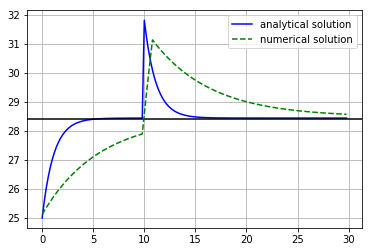

In [33]:
# 
plt.plot(T_stream_list.T_stream, color='blue', label='analytical solution')
plt.axhline(y=28.4, color='black')  # T_equilibrium temperature
plt.plot(T_stream_list2.T_stream, linestyle='dashed', color='green', label='numerical solution')
plt.grid()
plt.legend()

#plt.xlim([0,30])
#plt.ylim([24,23])

# -----------------------------------------------------------------------------------------
#   Loop to loop through different types of power plants
# -----------------------------------------------------------------------------------------

In [12]:
# --------------------------------------------------
#  loop through hours  - use q_surf
# ---------------------------------------
#depth(m), T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec), q_na (kcal/m2*sec), 
#    wind (m/sec), hour power plant effluent is discharged (hr), time step (hr)

input_vars_loop = pd.DataFrame([4,  18.5,  20, 900,  0.02, 0.05,  2, 30, 0.1])
input_vars = input_vars.transpose()
#input_vars.columns = ['depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 60 # final hour

input_vars = pd.DataFrame([50,  4,  18.5,  20, 900,  0.02, 0.05,  2, 0, 30, 0.1])
#input_vars = pd.DataFrame([1000,  2,  10,  25, 900,  0.02, 0.05,  2, 0, 5, 0.05])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 60 # final hour


power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [10,100,1000,10000] # discharge range (m3/sec)
Q_range = [50,500,5000,50000] # discharge range (m3/sec)

T_stream_tot = []
scenarios_tot_Q = []
scenarios_tot_P = []
# ----- establish time series with power plant impulse
impulse_time_series = impseq(int(input_vars['power_plant_hr'][0]),hr1,hr2)

for power_x in power_plant_range:
    
    for flow_x in Q_range:
        
        first_run = True
        T_stream_list2 = []

        for i in range(len(impulse_time_series)):

            steps_per_hr = list(range(0,int(1/input_vars['time_step'])))

            #print(len(steps_per_hr))
            if len(steps_per_hr) < 1:
                steps_per_hr =  list([1])
            #print(steps_per_hr)
            for j in steps_per_hr:

                # -------------- establish initial stream temperature ------------
                if first_run:
                    T_stream_x = input_vars['T_stream_i']
                    first_run = False

                # ------------ use previous temperature for stream T ----------
                else:
                    T_stream_x = T_stream_new

                # ------------- calculate surface energy, T_equil., and k_coeff -------    
                q_surf, T_eq, k_coeff = calc_surf_energy(T_stream_x,input_vars['T_dry_bulb'],input_vars['vap_press'],
                                                     input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

                # -------------------- calculate power plant efficiency ----------------
                q_power = power_plant_efficiency(power_x)

                # ------------------- calculate change in stream T from power plant and T_equil ----------
                T_stream_new = calc_power_energy2(T_stream_x, q_surf, k_coeff, q_power, 
                                             flow_x, input_vars['depth'], impulse_time_series, i,input_vars['time_step'] )
                T_stream_list2.append(T_stream_new)
                
                
        scenarios_tot_Q.append(flow_x)
        scenarios_tot_P.append(power_x)
        T_stream_tot.append(T_stream_list2)
    

[100, 1000]

# -----------------------------------------------------------------------------------------
#   Plots
# -----------------------------------------------------------------------------------------

In [15]:
#T_stream_list_1 = T_stream_list
#T_stream_list_0_5 = T_stream_list
T_stream_list_0_1 = T_stream_list
#T_stream_list_0_01 = T_stream_list

In [19]:
T_stream_list_25 = T_stream_list
#T_stream_list_15 = T_stream_list


(14.5, 26)

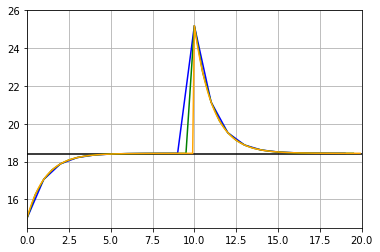

In [315]:
plt.plot(T_stream_list_1.T_stream, color='blue')
plt.axhline(y=18.4, color='black')
plt.plot(T_stream_list_0_5.T_stream, color='green')
plt.plot(T_stream_list_0_1.T_stream, color='orange')
#plt.plot(T_stream_list_0_01.T_stream, color='red')
plt.grid()

plt.xlim([0,20])
plt.ylim([14.5,26])

(14.5, 33)

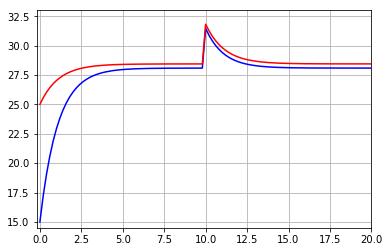

In [27]:
plt.plot(T_stream_list_15.T_stream, color='blue')
#plt.axhline(y=18.4, color='black')
plt.plot(T_stream_list_25.T_stream, color='red')
plt.grid()

plt.xlim([-0.2,20])
plt.ylim([14.5,33])

In [28]:
2 * 3600 * 3/1000

21.6

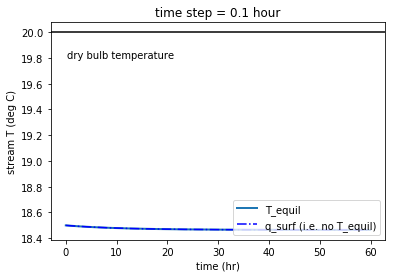

In [176]:
# -------------------------
#  Plot to experiment
# ------------------------
time_len = np.arange(0,hr2,input_vars['time_step'][0])
plt.title('time step = 0.1 hour')
plt.plot(time_len,T_stream_list,linewidth=2, label='T_equil')
plt.plot(time_len,T_stream_list2, linestyle='dashdot', color='blue', label='q_surf (i.e. no T_equil)')
plt.axhline(y=20, color='black')
plt.xlabel('time (hr)')
plt.ylabel('stream T (deg C)')
plt.legend(loc=4)
plt.text(0.2,19.8,'dry bulb temperature')

In [208]:
i

15

In [16]:
delta_T = []
for i in range(0,len(T_stream_tot)):
    delta_T.append(np.max(T_stream_tot[i])-np.min(T_stream_tot[i]))

8.10902012804
0.810292753853
0.0808400164554
0.0345903334188
16.2296900857
1.62087849621
0.161886897746
0.0339956108757
24.3659272228
2.43155374274
0.242934629082
0.033400865206
32.5234240576
3.24232112186
0.323983212878
0.0329536562717


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


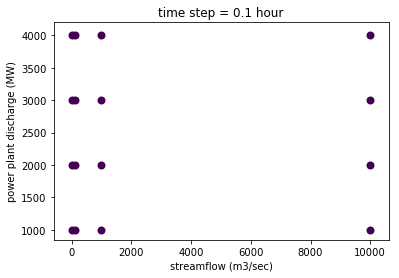

In [238]:
# -------------------------
#  Plot to experiment
# ------------------------


time_len = np.arange(0,hr2,input_vars['time_step'][0])
plt.title('time step = 0.1 hour')
for i in range(0,len(T_stream_tot)):
    #delta_T = np.max(T_stream_tot[i])-np.min(T_stream_tot[i])
    plt.scatter(scenarios_tot[i][0],scenarios_tot[i][1],linewidth=2, c=delta_T[i])
    print(delta_T[i])
    

plt.xlabel('streamflow (m3/sec)')
plt.ylabel('power plant discharge (MW)')
plt.legend(loc=4)


In [295]:
delta_T = []
for i in range(0,len(T_stream_tot)):
    delta_T.append(np.max(T_stream_tot[i])-np.min(T_stream_tot[i]))

In [300]:
scenarios_tot_Q

[50,
 500,
 5000,
 50000,
 50,
 500,
 5000,
 50000,
 50,
 500,
 5000,
 50000,
 50,
 500,
 5000,
 50000]

In [22]:
delta_T

[1.6208784962073004,
 0.16188689774612897,
 0.033995610875720672,
 0.035066094806150971,
 3.2423211218642223,
 0.32398321287848475,
 0.032953656271732967,
 0.034947155846342781,
 4.8641432860780611,
 0.48608294757063675,
 0.048421501411883838,
 0.034828215961876907,
 6.4863680347934114,
 0.64818612134068587,
 0.06463074199051988,
 0.034709275152696506]

AttributeError: 'module' object has no attribute 'set_xscale'

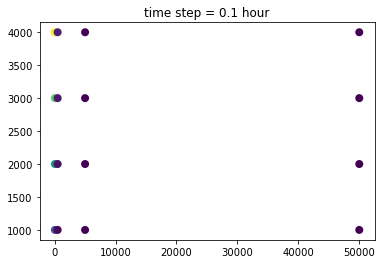

In [297]:
# -------------------------
#  Plot to experiment
# ------------------------


time_len = np.arange(0,hr2,input_vars['time_step'][0])
plt.title('time step = 0.1 hour')
plt.scatter(scenarios_tot_Q,scenarios_tot_P,linewidth=2, c=delta_T[:])

plt.set_xscale('log')

plt.xlabel('streamflow (m3/sec)')
plt.ylabel('power plant discharge (MW)')
plt.legend(loc=4)


In [14]:
from pylab import *
import matplotlib.pyplot  as pyplot

(100, 4900)

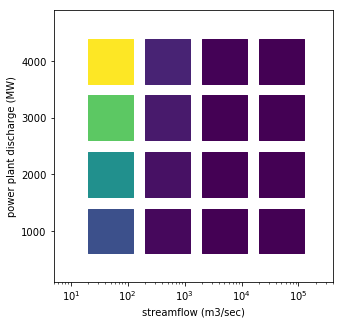

In [21]:
fig = pyplot.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)

line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2000, c=delta_T[:])
#plt.xlim([10,10000])
ax.set_xlabel('streamflow (m3/sec)')
ax.set_ylabel('power plant discharge (MW)')
ax.set_xscale('log')
ax.set_xlim(5,400000)
ax.set_ylim(100,4900)

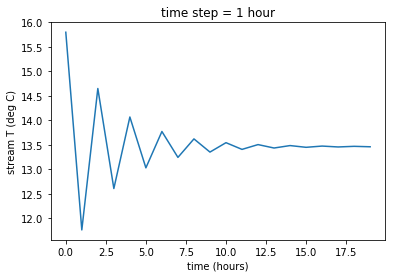

In [90]:
plt.title('time step = 1 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

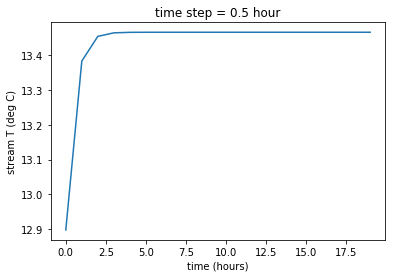

In [93]:
plt.title('time step = 0.5 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

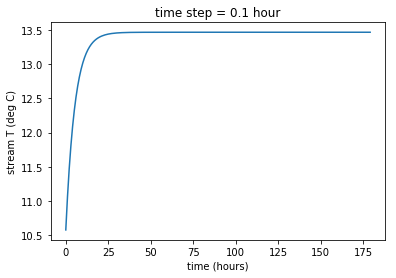

In [96]:
plt.title('time step = 0.1 hour')
plt.plot(T_stream_list)
plt.xlabel('time (hours)')
plt.ylabel('stream T (deg C)')

# --------------------------------------------------------------------------
#         Practice (Extra) code
# --------------------------------------------------------------------------

In [76]:
def calc_power_energy(T_stream, T_eq, k_coeff, q_power, Q, impulse_fxn, hrx):
    print('power input: ', q_power, 'impulse: ',  impulse_fxn[hrx-1], 'water_dense: ',water_density, 'cp',c_p_j,'Q: ', Q)
    hrx = hrx - 1 # to match the python index system where 0 is first index
    power_x  = (q_power * impulse_fxn[hrx])/(water_density*c_p_j*Q)
    stream_x = k_coeff * (T_eq - T_stream)
    dT = stream_x + power_x
    print('power: ',power_x,'stream_x: ',stream_x.values, 'dT: ',dT.values)
    T_new = dT + T_stream
    
    return T_new

In [67]:
q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                                         input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

dayx = 1
impulse_fxn = impseq(dayx,1,10)
T_stream_new = calc_power_energy(input_vars['T_stream_i'].values, T_eq, k_coeff, input_vars['power_plant'].values, 
                                 input_vars['Q'].values, impulse_fxn, dayx)
print(T_stream_new)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [72]:
impulse_time_series = impseq(1,hr1,hr2)

q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                            input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

T_stream_new = calc_power_energy(input_vars['T_stream_i'], T_eq, k_coeff, 10000, 
                             input_vars['Q'].values, impulse_time_series, 1)
#print(input_vars['T_stream_i'].values, T_stream_new.values)

power input:  10000 impulse:  1 water_dense:  1000 cp 4148.4 Q:  [ 50.]
power:  [  4.82113586e-05] stream_x:  0    0.373923
dtype: float64


In [68]:
              read(38,*) z, T_i, dbt,ea, q_ns, q_na, wind
              call energy(T_i, q_surf, dbt, ea,q_ns, q_na, wind, T_equil, k_coeff)
              q_dot=(q_surf/(z*rfac))
              q_surf_tot = q_surf_tot + q_dot*dt_calc ! adding up surface energy


SyntaxError: invalid syntax (<ipython-input-68-786fb29d0af1>, line 1)

In [20]:
len(pd.date_range(dt.datetime(1949,1,1),dt.datetime(2010,9,30), freq='H'))

541249

In [22]:
len(pd.date_range(dt.datetime(1950,1,1),dt.datetime(2010,9,30), freq='H'))

532489